In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


Word2Vec는 Word To Vector의 줄임말이다.  
딥러닝 모델은 입력으로 수치값을 받기 때문에 자연어 처리 분야에서 단어(word)를 어떻게 수치(vector)로 변환하느냐가 딥러닝 모델의 성능을 결정하는 중요한 요소이다.

Word2Vec의 장점은 의미가 비슷한 단어는 벡터 공간에서도 서로 가까운 위치에 존재하게 되는 비지도 학습으로 말뭉치 데이터만 있으면 손쉽게 Word2Vec를 구현할 수 있다.

데이터 획득

In [2]:
corpus = ['king is a strong man', 
    'queen is a wise woman', 
    'boy is a young man', 
    'girl is a young woman',
    'prince is a young king', 
    'princess is a young queen', 
    'man is strong', 
    'woman is pretty',
    'prince is a boy will be king', 
    'princess is a girl will be queen'
]
print(corpus)

['king is a strong man', 'queen is a wise woman', 'boy is a young man', 'girl is a young woman', 'prince is a young king', 'princess is a young queen', 'man is strong', 'woman is pretty', 'prince is a boy will be king', 'princess is a girl will be queen']


데이터 전처리  
불용어(stop words) 제거하기  
불용어란 학습에 도움이 되지도 않으면서 빈번하게 발생되는 단어를 의미하며 효율적인 학습을 위해서 불용어를 데이터에서 제거한다.

In [3]:
# 불용어 제거 함수
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be'] # 불용어 정의
    results = [] # 불용어를 제거한 결과를 저장해서 리턴시킬 빈 리스틀 선언한다.
    # 불용어를 제거할 문장을 한 줄씩 읽어가며 반복한다.
    for text in corpus:
        # print(text)
        # 불용어를 제거하기 위해서 공백을 경계로 문장을 단어 단위로 나눈다.
        temp = text.split()
        # print(temp)
        # 불용어 개수만큼 반복하며 문장에서 불용어를 제거한다.
        for stop_word in stop_words:
            # 불용어를 제거할 문장에 불용어가 없을때까지 반복한다.
            while stop_word in temp:
                temp.remove(stop_word)
            # ===== while
        # ===== for stop_word
        # print(temp)
        # 불용어가 제거된 단어 사이에 공백을 넣어서 불용어가 제거된 문장을 만든다.
        # print(' '.join(temp))
        results.append(' '.join(temp))
    # ===== for text
    return results

In [4]:
# print(remove_stop_words(corpus))
corpus = remove_stop_words(corpus)
print(corpus)

['king strong man', 'queen wise woman', 'boy young man', 'girl young woman', 'prince young king', 'princess young queen', 'man strong', 'woman pretty', 'prince boy king', 'princess girl queen']


데이터 전처리  
불용어를 제거한 단어의 중복을 제거한다.

In [5]:
# 불용어를 제거한 후 데이터에 존재하는 단어들은 다음과 같다.
words = []
for text in corpus:
    for word in text.split():
        words.append(word)
print(words) # 중복되는 단어가 존재한다.

['king', 'strong', 'man', 'queen', 'wise', 'woman', 'boy', 'young', 'man', 'girl', 'young', 'woman', 'prince', 'young', 'king', 'princess', 'young', 'queen', 'man', 'strong', 'woman', 'pretty', 'prince', 'boy', 'king', 'princess', 'girl', 'queen']


In [6]:
words = set(words)
print(words) # 중복되는 단어가 존재하지 않는다.

{'strong', 'king', 'queen', 'woman', 'wise', 'prince', 'pretty', 'boy', 'girl', 'young', 'princess', 'man'}


데이터 전처리  
단어별 인덱스 매핑

In [7]:
for index, word in enumerate(words):
    print(index, word)

0 strong
1 king
2 queen
3 woman
4 wise
5 prince
6 pretty
7 boy
8 girl
9 young
10 princess
11 man


In [8]:
# word를 key로 하고 index를 value로 하는 딕셔너리를 만든다.
word2int = {}
for index, word in enumerate(words):
    word2int[word] = index
print(word2int)

{'strong': 0, 'king': 1, 'queen': 2, 'woman': 3, 'wise': 4, 'prince': 5, 'pretty': 6, 'boy': 7, 'girl': 8, 'young': 9, 'princess': 10, 'man': 11}


<img src="./skipgram1.png" align="left" width="1400"/>

<img src="./skipgram2.png" align="left" width="1400"/>

<img src="./skipgram3.png" align="left" width="1400"/>

<img src="./skipgram4.png" align="left" width="1400"/>

<img src="./skipgram5.png" align="left" width="1400"/>

<img src="./skipgram6.png" align="left" width="1400"/>

skip gram 방식으로 각 단어별 레이블을 데이터프레임으로 생성한다.

In [9]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
print(sentences)

[['king', 'strong', 'man'], ['queen', 'wise', 'woman'], ['boy', 'young', 'man'], ['girl', 'young', 'woman'], ['prince', 'young', 'king'], ['princess', 'young', 'queen'], ['man', 'strong'], ['woman', 'pretty'], ['prince', 'boy', 'king'], ['princess', 'girl', 'queen']]


In [10]:
WINDOW_SIZE = 2
data = []
# 단어별 레이블을 생성할 문장의 개수만큼 반복하며 레이블을 생성한다.
for sentence in sentences:
    # print('sentence: {}'.format(sentence))
    for index, word in enumerate(sentence):
        # print('index: {}, word: {}'.format(index, word))
        for neighbor in sentence[max(index - WINDOW_SIZE, 0):min(index + WINDOW_SIZE, len(sentence)) + 1]:
            if word != neighbor:
                # print('word: {}, neighbor: {}'.format(word, neighbor))
                data.append([word, neighbor])
            # ===== if
        # ===== for neighbor
    # ===== for index, word
    # print('=' * 80)
# ===== for sentence

In [11]:
df = pd.DataFrame(data, columns=['input', 'lable'])
df

,input,lable
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


Word2Vec 모델 구현

<img src="./word2vec.png" align="left" width="800"/>

In [12]:
ONE_HOT_DIM = len(words)

# word를 key로 하고 index를 value로 하는 딕셔너리를 원-핫 인코딩으로 전환하는 함수를 만든다.
def one_hot_encoding(index):
    # print(index)
    one_hot = np.zeros(ONE_HOT_DIM)
    one_hot[index] = 1
    # print(one_hot)
    return one_hot

In [13]:
# for key in word2int:
    # print(key, word2int[key])
    # result = one_hot_encoding(word2int[key])
# =================================================================
# for value in word2int.values():
    # print(value)
    # result = one_hot_encoding(value)
# =================================================================
for key, value in word2int.items():
    # print(key, value)
    result = one_hot_encoding(value)
# =================================================================
    print(result)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [14]:
X = [] # 입력 단어가 원-핫 인코딩으로 변환된 결과를 기억할 빈 리스트를 선언한다.
Y = [] # 입력 단어에 따른 레이블이 원-핫 인코딩으로 변환된 결과를 기억할 빈 리스트를 선언한다.

# 데이터프레임에 저장된 입력 단어와 입력 단어에 따른 레이블을 원-핫 인코딩으로 변환해서 X, Y 리스트에 저장한다.
for x, y in zip(df.input, df.lable):
    # print(x, y)
    X.append(one_hot_encoding(word2int[x]))
    Y.append(one_hot_encoding(word2int[y]))

for i in range(len(words)):
    print('{:7s} {} - {:7s} {}'.format(df.input[i], X[i], df.lable[i], Y[i]))

king    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - strong  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
king    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - man     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
strong  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - king    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
strong  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - man     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
man     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] - king    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
man     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] - strong  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
queen   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - wise    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
queen   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] - woman   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
wise    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] - queen   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
wise    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] - woman   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
woman   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] - queen   [0. 

In [15]:
# Word2Vec 모델을 만든다.
# 넘파이의 array() 메소드는 파이썬의 리스트나 튜플을 넘파이 배열로 만든다.
# 넘파이의 asarray() 메소드는 인수로 지정한 데이터가 이미 넘파이 배열 형태라면 복사만 한다.
x_train = np.asarray(X) # 입력 데이터
y_train = np.asarray(Y) # 입력 데이터에 따른 레이블
# print(x_train[0], y_train[0])

# 입력 데이터와 입력 데이터에 따른 레이블을 저장할 placeholder를 선언한다.
x = tf.placeholder(dtype=tf.float32, shape=[None, ONE_HOT_DIM]) # 입력 데이터를 저장할 placeholder
y = tf.placeholder(dtype=tf.float32, shape=[None, ONE_HOT_DIM]) # 입력 데이터에 다른 레이블을 저장할 placeholder

# 히든 레이어
W1 = tf.Variable(tf.truncated_normal([ONE_HOT_DIM, 2], stddev=0.1))
hidden_layer = tf.matmul(x, W1)

# 출력 레이어
W2 = tf.Variable(tf.truncated_normal([2, ONE_HOT_DIM], stddev=0.1))
b2 = tf.Variable(tf.truncated_normal([1], stddev=0.1))

# 예측
predict = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, W2), b2))

# 손실 함수 - 크로스 엔크로피
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(predict), axis=1))

# 최적화 - 경사 하강법
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

학습 시킨다.

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(50001):
    _, loss_ = sess.run([train, loss], feed_dict={x: x_train, y: y_train})
    if epoch % 2500 == 0:
        print('epoch: {:5d}, loss: {:7.5f}'.format(epoch, loss_))

epoch:     0, loss: 2.48515
epoch:  2500, loss: 2.47223
epoch:  5000, loss: 2.38652
epoch:  7500, loss: 2.16277
epoch: 10000, loss: 2.05123
epoch: 12500, loss: 1.99061
epoch: 15000, loss: 1.94104
epoch: 17500, loss: 1.90045
epoch: 20000, loss: 1.87466
epoch: 22500, loss: 1.85798
epoch: 25000, loss: 1.84542
epoch: 27500, loss: 1.83510
epoch: 30000, loss: 1.82634
epoch: 32500, loss: 1.81883
epoch: 35000, loss: 1.81234
epoch: 37500, loss: 1.80671
epoch: 40000, loss: 1.80178
epoch: 42500, loss: 1.79744
epoch: 45000, loss: 1.79357
epoch: 47500, loss: 1.79010
epoch: 50000, loss: 1.78697


히든 레이어의 값(Word2Vec) 추출하기

In [17]:
vectors = sess.run(W1)
for key, value in word2int.items():
    print('{:8s} {}'.format(key, vectors[value]))

strong   [4.459051  1.1383444]
king     [ 0.9186223  -0.17773663]
queen    [-0.30981433  1.2108411 ]
woman    [-0.71716785  0.47279075]
wise     [-0.998188   3.0717313]
prince   [1.8264877  0.05937288]
pretty   [-0.03134853  2.2822556 ]
boy      [2.1284046  0.71618474]
girl     [-0.4868542  3.1150627]
young    [0.18989101 0.21893698]
princess [-1.1921594  2.7558503]
man      [ 0.8179477 -0.4435426]


Word2Vec를 2차원 공간에 시각화 한다.

In [18]:
# Word2Vec의 단어에 따른 히든 레이어 값을 데이터프레임으로 저장한다.
w2v_df = pd.DataFrame(vectors, columns=['x1', 'x2'])
# words는 set이고 set은 순서가 없으므로 에러가 발생된다. => 3.6 버전은 에러가 발생하지 않았다.
# set이 순서가 없다는 에러가 발생되면 list() 생성자 함수로 리스트로 만들어서 추가한다.
w2v_df['word'] = list(words)
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,strong,4.459051,1.138344
1,king,0.918622,-0.177737
2,queen,-0.309814,1.210841
3,woman,-0.717168,0.472791
4,wise,-0.998188,3.071731
5,prince,1.826488,0.059373
6,pretty,-0.031349,2.282256
7,boy,2.128405,0.716185
8,girl,-0.486854,3.115063
9,young,0.189891,0.218937


In [19]:
import matplotlib.pyplot as plt

<Figure size 800x600 with 0 Axes>

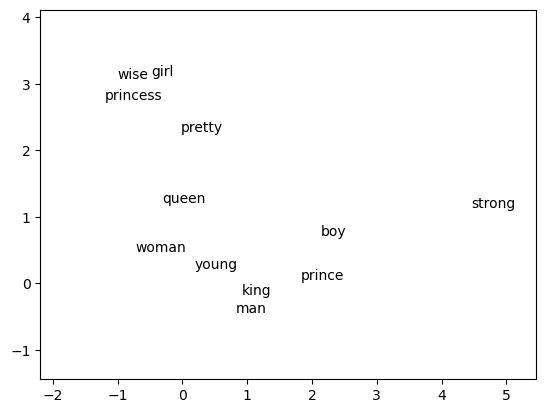

In [21]:
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
for word, x1, x2 in zip(w2v_df.word, w2v_df.x1, w2v_df.x2):
    ax.annotate(word, (x1, x2))
    
x_axis_min = np.amin(vectors, axis=0)[0] - 1.0
x_axis_max = np.amax(vectors, axis=0)[0] + 1.0
y_axis_min = np.amin(vectors, axis=0)[1] - 1.0
y_axis_max = np.amax(vectors, axis=0)[1] + 1.0
    
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.show()